In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import mygene, glob
import seaborn as sns
import subprocess
import re
%matplotlib inline

In [2]:
#sns.set_style("white")
#sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 1.5})
sns.set_theme(context='talk', style='white', palette=sns.color_palette("Set2"), font='sans-serif', font_scale=1.2, color_codes=True, rc={"lines.linewidth": 1.5})

[Text(0, 0, 'Collapsed'),
 Text(1, 0, 'Chained'),
 Text(2, 0, 'SQANTI3'),
 Text(3, 0, 'Annotated')]

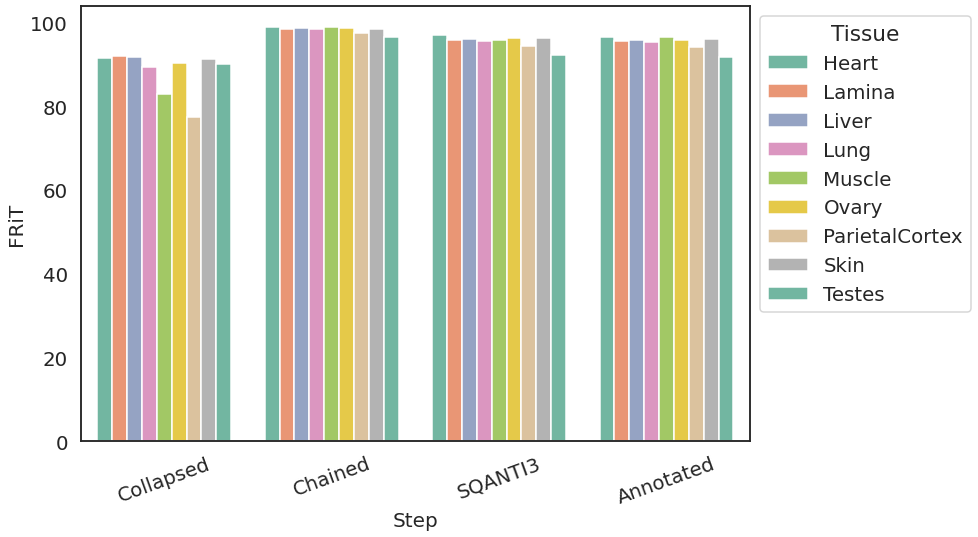

In [16]:
enrichment_df = pd.DataFrame(columns = ['sample', 'tissue', 'step', 'featureType', 'percent'])
for i in glob.glob("../Results/Enrichment/*/AH*/*tsv"):
    step, name = i.split("/")[3:5]
    sample, tissue = name.split('_')
    data = pd.read_csv(i, sep = '\t')
    data[['step', 'sample', 'tissue']] = step, sample, tissue
    data = data[['sample', 'tissue', 'step', 'featureType', 'percent']]
    enrichment_df = pd.concat([enrichment_df, data])
enrichment_df = enrichment_df[enrichment_df['featureType'] == 'transcript'].groupby(['tissue', 'step']).mean().reset_index()
fig, ax = plt.subplots(figsize = (12,8))

sns.barplot(data = enrichment_df, x = 'step', 
            hue = 'tissue', y = 'percent', ax = ax, hue_order = enrichment_df['tissue'].unique(),
           order = ['collapsed', 'Chained', 'SQANTI3', 'Annotated'], palette = sns.color_palette("Set2"))
plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1, title = "Tissue")
ax.set_xlabel('Step', fontsize = 20)
ax.set_ylabel('FRiT', fontsize = 20)
ax.set_xticklabels(labels = ['Collapsed', 'Chained', 'SQANTI3', 'Annotated'], rotation = 20)

In [4]:
salmon_mapping_rate_df = pd.DataFrame(columns = ['sample', 'tissue', 'step', 'mappingRate'])
for i in glob.glob("../Results/salmon/*/AH*/logs/salmon_quant.log"):
    output = subprocess.run(['grep', 'Mapping rate', i], stdout=subprocess.PIPE, text=True,)
    rate = float(re.match('.+Mapping rate = ([\d\.]+)%', output.stdout)[1])
    step, name = i.split("/")[3:5]
    sample, tissue = name.split('_')
    salmon_mapping_rate_df = pd.concat([salmon_mapping_rate_df, 
                                        pd.DataFrame([[sample, tissue, step, rate]], 
                                                     columns = ['sample', 'tissue', 'step', 'mappingRate'])])
    
#for i in glob.glob("parsed_transcripts_no_itp_nmd/AH*/logs/salmon_quant.log"):
#    output = subprocess.run(['grep', 'Mapping rate', i], stdout=subprocess.PIPE, text=True,)
#    rate = float(re.match('.+Mapping rate = ([\d\.]+)%', output.stdout)[1])
#    step, sample = i.split("/")[0:2]
#    tissue = 'ParietalCortex'
#    salmon_mapping_rate_df = pd.concat([salmon_mapping_rate_df, 
#                                        pd.DataFrame([[sample, tissue, step, rate]], 
#                                                     columns = ['sample', 'tissue', 'step', 'mappingRate'])])

In [5]:
salmon_mapping_rate_df = salmon_mapping_rate_df[~(salmon_mapping_rate_df['step'] == 'collapsed')]

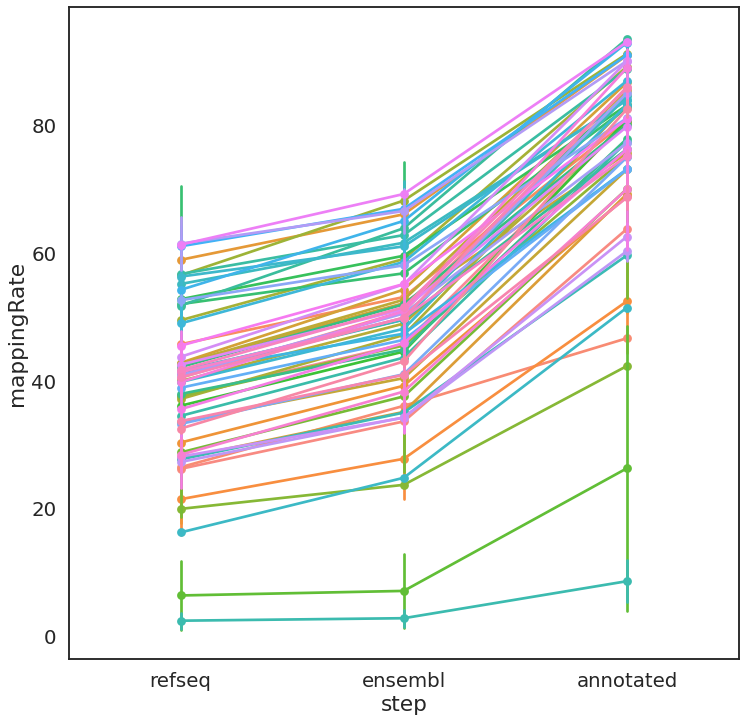

In [10]:
fig, ax = plt.subplots(figsize = (12,12))
#grid = sns.FacetGrid(stats, col = 'rep', row = 'refAnno', margin_titles=True, legend_out = True, height = 8)
sns.pointplot(data = salmon_mapping_rate_df[(salmon_mapping_rate_df['step'].isin(['annotated', 'refseq', 'ensembl']))], x = 'step', y = 'mappingRate', hue = 'tissue', ax = ax, legend = False)
ax.get_legend().remove()

In [3]:
import os, subprocess
f = []
for (dirpath, dirnames, filenames) in os.walk("../Results/mapping/stats/"):
    f.extend(filenames)
    break
stats=pd.DataFrame()
for file in f:
    grep = subprocess.Popen(('grep', '^SN', "../Results/mapping/stats/" + file), stdout=subprocess.PIPE)
    output = subprocess.check_output(('cut', '-f', '2-'), stdin=grep.stdout)
    grep.wait()
    if output.decode('ascii') == '':
        continue
    stats = pd.concat([stats, pd.DataFrame({key: value for (key, value, *comment) in [tuple(pair.split('\t')) for pair in output.decode('ascii').strip().split('\n')]}, index = [file.replace('.stats.txt','')])])
stats = stats.reset_index()
temp = stats['index'].str.split('_', expand = True)
stats['refAnno'] = temp.iloc[:,0]
stats['rep'] = temp.iloc[:,1]
stats['tissue'] = temp.iloc[:,2:5].astype('str').agg('_'.join, axis=1).str.replace('-None', '')
stats['percentage of properly paired reads (%):'] = stats['percentage of properly paired reads (%):'].astype(float)
stats = stats[~stats['tissue'].str.contains('Ribozero')]
stats['rep_tissue'] = stats['rep'] + '_' + stats['tissue']

In [4]:
Isoseq_tissues = ['Lamina', 'Ovary', 'Lung', 'Heart', 'Muscle', 'Skin','Liver', 'Testes', 'ParietalCortex']
stats['inIsoSeq'] = np.where(stats['tissue'].isin(Isoseq_tissues), 'True', 'False')

<AxesSubplot:xlabel='refAnno', ylabel='percentage of properly paired reads (%):'>

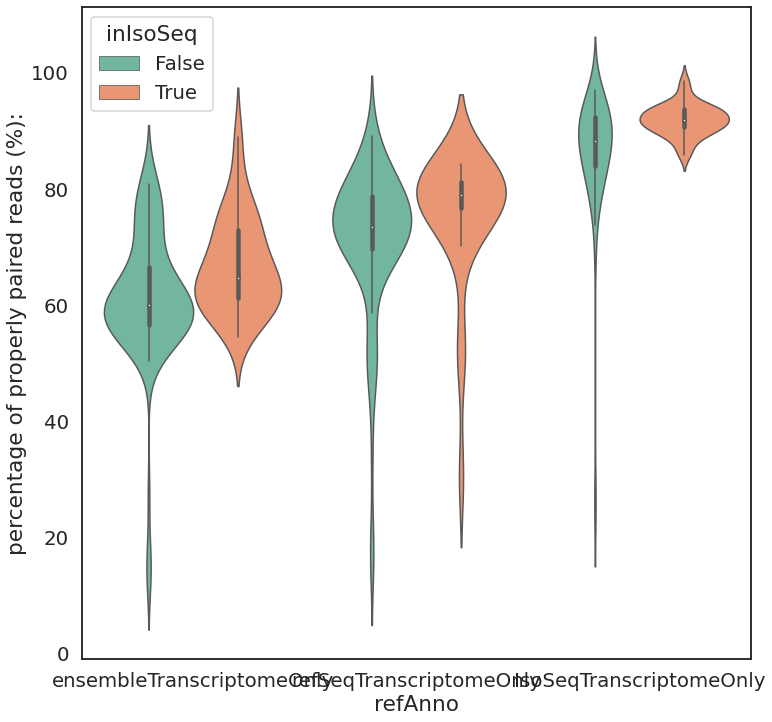

In [5]:
fig, ax = plt.subplots(figsize = (12,12))
#grid = sns.FacetGrid(stats, col = 'rep', row = 'refAnno', margin_titles=True, legend_out = True, height = 8)
sns.violinplot(data = stats, x = 'refAnno', y = 'percentage of properly paired reads (%):', ax = ax, hue = 'inIsoSeq', 
              order = ['ensembleTranscriptomeOnly', 'refSeqTranscriptomeOnly', 'IsoSeqTranscriptomeOnly'])

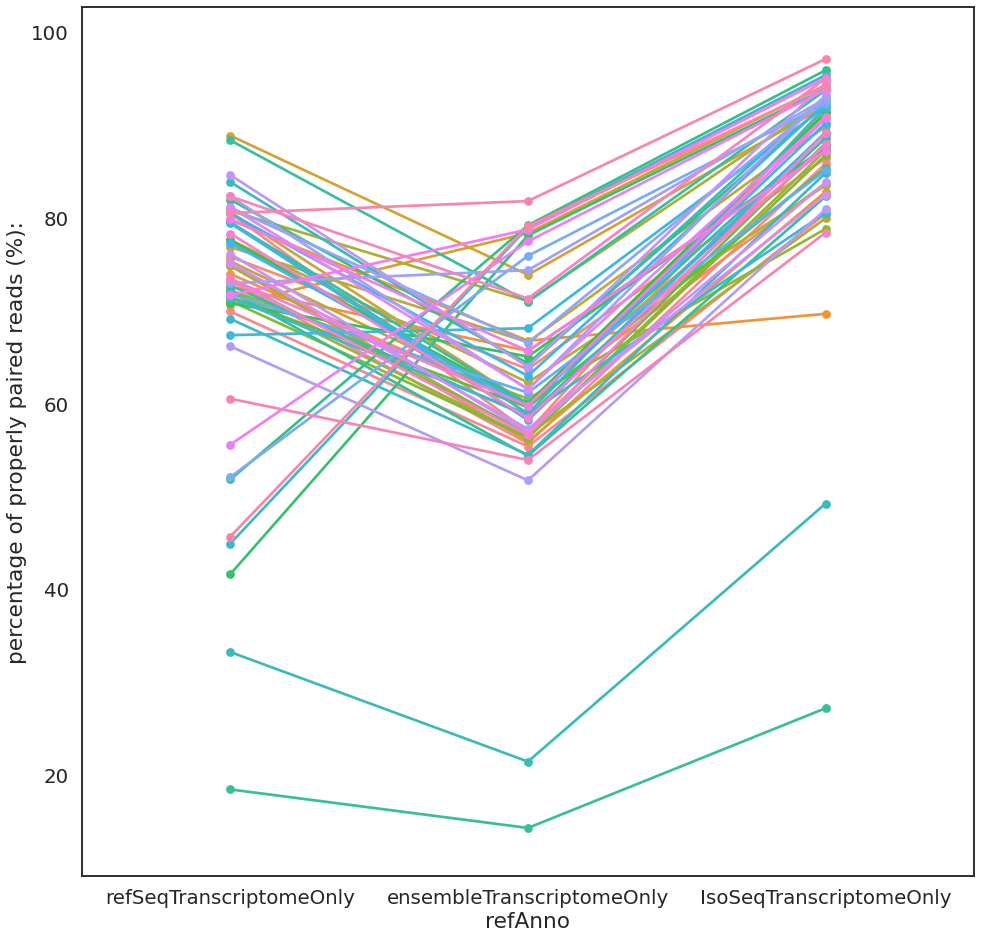

In [6]:
fig, ax = plt.subplots(figsize = (16,16))
#grid = sns.FacetGrid(stats, col = 'rep', row = 'refAnno', margin_titles=True, legend_out = True, height = 8)
#sns.pointplot(data = stats[stats['tissue'].isin(Isoseq_tissues)], x = 'refAnno', y = 'percentage of properly paired reads (%):', ax = ax,
#              legend = False, order = ['ensembleTranscriptomeOnly', 'refSeqTranscriptomeOnly', 'IsoSeqTranscriptomeOnly'],
#              errwidth = 0, color = 'red', hue = 'tissue')
#sns.pointplot(data = stats[~stats['tissue'].isin(Isoseq_tissues)], x = 'refAnno', y = 'percentage of properly paired reads (%):', ax = ax,
#              legend = False, order = ['ensembleTranscriptomeOnly', 'refSeqTranscriptomeOnly', 'IsoSeqTranscriptomeOnly'],
#              errwidth = 0, color = 'red',hue = 'tissue')
sns.pointplot(data = stats, x = 'refAnno', y = 'percentage of properly paired reads (%):', ax = ax,
              legend = False, order = ['refSeqTranscriptomeOnly', 'ensembleTranscriptomeOnly', 'IsoSeqTranscriptomeOnly'],
              errwidth = 0, hue = 'tissue')
ax.get_legend().remove()
#ax.set_xticklabels('')

In [7]:
ref_comp = stats[['percentage of properly paired reads (%):', 'refAnno', 'rep', 'tissue']].pivot(index = ['rep', 'tissue'],
                                                                                      columns = 'refAnno',
                                                                                      values = 'percentage of properly paired reads (%):').dropna()
ref_comp['diff'] = ref_comp['IsoSeqTranscriptomeOnly'] - ref_comp[['ensembleTranscriptomeOnly', 'refSeqTranscriptomeOnly']].max(axis = 1)
ref_comp['inIsoSeq'] = np.where(ref_comp.index.get_level_values(level=1).isin(Isoseq_tissues), True, False)

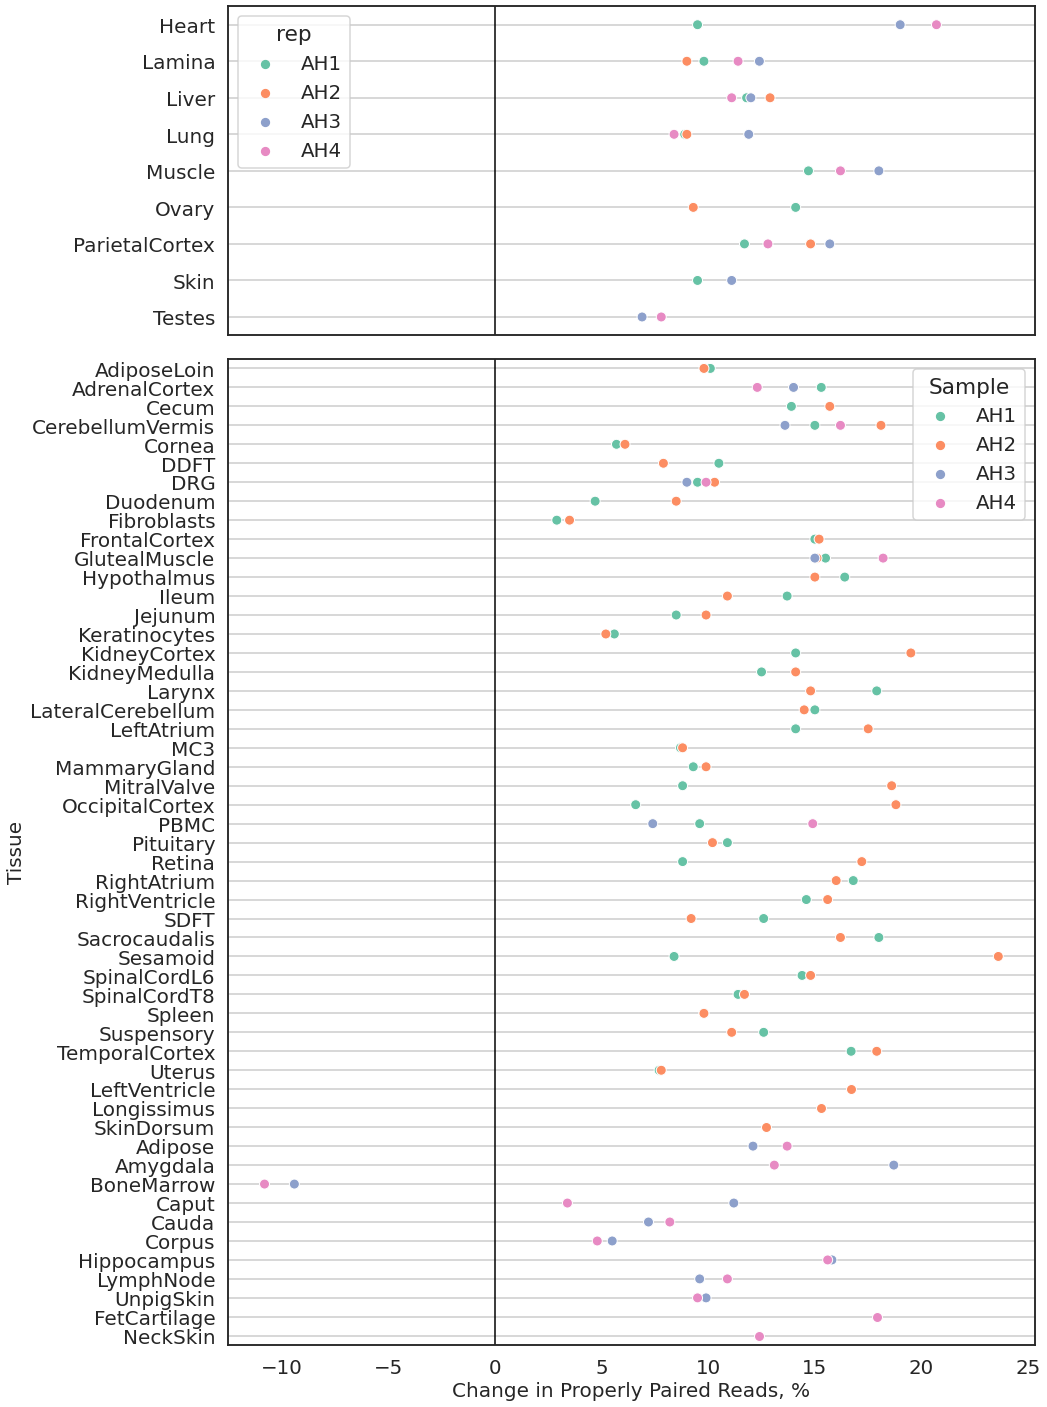

In [13]:
fig, axes = plt.subplots(2, 1, figsize = (15, 20), sharex=True, sharey=False, gridspec_kw={'height_ratios': [1, 3]})
sns.stripplot(data = ref_comp[ref_comp['inIsoSeq']].reset_index(), x = 'diff', y = 'tissue', hue = 'rep', size=10,
              orient="h", jitter=False, linewidth=1, edgecolor="w", ax = axes[0])
sns.stripplot(data = ref_comp[~ref_comp['inIsoSeq']].reset_index(), x = 'diff', y = 'tissue', hue = 'rep', size=10,
              orient="h", jitter=False, linewidth=1, edgecolor="w", ax = axes[1])
for ax in axes:
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_xticklabels(ax.get_xticklabels(),fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=20)
    ax.axvline(x = 0, color = 'black')
axes[1].set_xlabel('Change in Properly Paired Reads, %', fontsize = 20)
#axes[1].set_ylabel('Tissue', fontsize = 20)
plt.ylabel('Tissue', fontsize = 20)
plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1, title = "Sample")
plt.tight_layout()